# Minimal Implementation for Dynamics of Specialization

In [96]:
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
from itertools import product

## Models

In [100]:
def state_mask(n_agents, n_0, n_1):
    # Mask for the state to state connections between layers
    mask = torch.eye(n_agents)
    mask = mask.repeat_interleave(n_0, 0).repeat_interleave(n_1, 1)
    return mask

def sparse_mask(sparsity, n_in, n_out):
    nb_non_zero = int(sparsity * n_in * n_out)
    w_mask = np.zeros((n_in, n_out), dtype=bool)
    # ind_in = rd.choice(np.arange(in_features),size=self.nb_non_zero)
    # ind_out = rd.choice(np.arange(out_features),size=self.nb_non_zero)

    ind_in, ind_out = np.unravel_index(
        np.random.choice(
            np.arange(n_in * n_out), nb_non_zero, replace=False
        ),
        (n_in, n_out),
    )
    w_mask[ind_in, ind_out] = True
    w_mask = torch.tensor(w_mask)
    return w_mask

def comms_mask(sparsity, n_agents, n_hidden): 
    mask = torch.zeros((n_agents*n_hidden, n_agents*n_hidden))
    for i, j in product(range(n_agents), repeat=2):
        if i != j:
            mask[i*n_hidden:(i+1)*n_hidden, j*n_hidden:(j+1)*n_hidden] = sparse_mask(sparsity, n_hidden, n_hidden)
    return mask

class masked_RNN(nn.RNN):
    def __init__(self, *args, masks, **kwargs):
        super().__init__(*args, **kwargs)
        [self.register_buffer(n, m) for n, m in masks.items()]

    def forward(self, input, hx=None):
        for n, p in self.named_parameters():
            if "weight_hh" in n:
                # print(p.shape, self.comms_mask.shape)
                p.data *= self.comms_mask
            elif "weight_ih" in n and n[-1] != "0":
                # print(p.shape, self.input_mask.shape)
                p.data *= self.state_mask
            elif "weight_ih" in n and n[-1] == "0":
                # print(p.shape, self.input_mask.shape)
                p.data *= self.input_mask

        return super().forward(input, hx=hx)


class Community(nn.Module):
    def __init__(
        self,
        agents_configs,
        connections_config,
        input_config,
        readout_config,
    ) -> None:
        super().__init__()

        self.is_community = True
        self.input_size, self.common_input = [
            input_config[k] for k in ["input_size", "common_input"]
        ]
        self.n_agents, self.hidden_size, self.n_layers = [
            agents_configs[k] for k in ["n_agents", "hidden_size", "n_layers"]
        ]
        self.sparsity = connections_config["sparsity"]
        self.output_size, self.common_readout = [
            readout_config[k] for k in ["output_size", "common_readout"]
        ]

        self.masks = {
            "input_mask": state_mask(self.n_agents, self.hidden_size, self.input_size),
            "state_mask": state_mask(self.n_agents, self.hidden_size, self.hidden_size),
            "comms_mask": comms_mask(self.sparsity, self.n_agents, self.hidden_size),
            "output_mask": state_mask(
                self.n_agents, self.output_size, self.hidden_size
            ),
        }

        self.core = masked_RNN(
            input_size=self.input_size * self.n_agents,
            hidden_size=self.hidden_size * self.n_agents,
            num_layers=self.n_layers,
            batch_first=False,
            bias=False,
            masks=self.masks,
        )

        [self.register_buffer(n, m) for n, m in self.masks.items()]

        if self.common_readout:
            self.readout = nn.Linear(self.n_agents * self.hidden_size, self.output_size)
        else:
            self.readout = nn.Linear(
                self.n_agents * self.hidden_size, self.output_size * self.n_agents
            )

    def forward(self, input):
        output, states = self.core(input)
        output = self.readout(output)
        if not self.common_readout:
            self.readout.weight.data *= self.output_mask
            output = torch.stack(output.split(self.output_size, -1), 1)

        return output, states

## Data

### Datasets

In [3]:
from community.data.datasets.generate import get_datasets_symbols, get_datasets_alphabet
from community.data.process import temporal_data

In [4]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512

In [111]:
n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents
nb_steps = 2

data_config = {
    "batch_size": 512,
    "data_size": None,  # np.array([30000, 5000]) ,
    "input_size": 28,
    "common_input": True,
    "use_cuda": use_cuda,
    "fix_asym": True,
    "permute_dataset": False,
    "seed": np.random.randint(100),
    "data_type": "double_digits",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "symbol_config": {},
    "split_classes": True,
    "nb_steps": nb_steps,
    "cov_ratio": 1,
    "noise_ratio": None,
    "random_start": False,
}

if "digits" in data_config["data_type"]:
    n_classes_per_digit = min(n_classes_per_digit, 10)
    n_classes = n_classes_per_digit * n_agents
    data_config["n_classes_per_digit"] = n_classes_per_digit

In [112]:
all_data = get_datasets_alphabet("../../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]

In [113]:
(datasets[0].data[1][:, 0] == datasets[0].data[1][:, 1]).float().mean()

tensor(0.)

In [114]:
def process_data(
    data,
    n_steps=2,
    common_input=True,
    flatten=True,
    noise_ratio=None,
    random_start=False,
):
    start_times = None
    data, start_times = temporal_data(
        data,
        n_steps=n_steps,
        flatten=flatten,
        noise_ratio=noise_ratio,
        random_start=random_start,
    )

    if common_input:
        data = data.transpose(1, 2)
        data = data.reshape(data.shape[0], data.shape[1], -1)

    return data, start_times

## Init

In [165]:
task = 'parity-digits-both'

agents_config = {"n_agents": 2, "hidden_size": 25, "n_layers": 1}
connections_config = {"sparsity": 10 / agents_config['hidden_size']**2}
input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
readout_config = {
    "output_size": data_config["n_classes_per_digit"] * (1 + (task == "sum")),
    "common_readout": False,
}

decision = ['last', 'max']

model = Community(agents_config, connections_config, input_config, readout_config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [166]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data)
data.shape
out, states = model(data)
out.shape


torch.Size([2, 2, 512, 10])

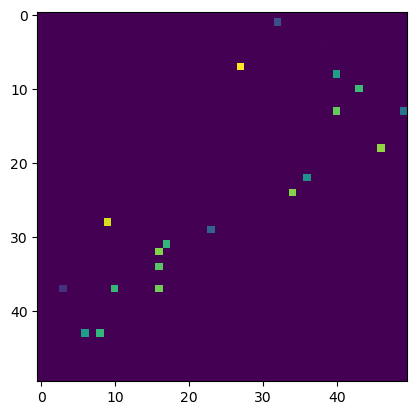

In [167]:
plt.imshow(model.core.weight_hh_l0.abs().cpu().data.numpy())

## Training

In [169]:
from community.data.tasks import get_task_target
from community.common.decision import get_decision
from community.common.training import get_acc, get_loss
from community.utils.nested import nested_mean, nested_sup, nested_round
import copy

In [175]:
output, _ = get_decision(out, *decision)
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])
get_acc(output, t_target)

TypeError: len() of a 0-d tensor

In [177]:
t_target.shape

torch.Size([2, 512])

In [149]:
training_config = {
    "n_epochs": 30,
    "task": "parity-digits",
}
config = {
    "agents": agents_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
}

In [150]:
def test_community(model, device, test_loader, config, show_all_acc=False):

    model.eval()
    test_loss = 0
    correct = 0
    acc = 0
    deciding_agents = []

    decision = config["decision"]
    task = config['training']["task"]

    with torch.no_grad() : 
        for data, target in test_loader:
            
            data, _ = process_data(
                    data,
                )
            t_target = get_task_target(target, task, n_classes_per_digit)
            output, _ = model(data)

            if decision is not None:
                output, deciding_ags = get_decision(output, *decision, target=t_target)
                both = decision[1] == "both"
            else:
                deciding_ags = None
                both = False

            try:
                if (
                    deciding_ags is not None
                    and test_loader.batch_size in deciding_ags.shape
                ):
                    deciding_agents.append(deciding_ags.cpu().data.numpy())
            except AttributeError:
                deciding_ags = None

            complete_loss = get_loss(output, t_target, both=both)
            loss = nested_mean(complete_loss)

            test_loss += loss
            test_acc = get_acc(output, t_target, both=both)
            acc += test_acc

    test_loss /= len(test_loader)
    acc /= len(test_loader)

    deciding_agents = np.array(deciding_agents)

    desc = str(
        " | Test set: Loss: {:.3f}, Accuracy: {}%".format(
            test_loss,
            np.round(100 * np.mean(acc)) if not show_all_acc else nested_round(acc),
        )
    )

    return desc, test_loss.cpu().data.item(), acc, deciding_agents
            

def train_community(
    model,
    train_loader,
    test_loader,
    optimizer,
    config,
    schedulers=None,
    n_epochs=None,
    use_tqdm=True,
    trials=(True, True),
    show_all_acc=False,
):
    n_epochs = config['training']["n_epochs"] if n_epochs is None else n_epochs
    task = config['training']["task"]
    decision = config["decision"]

    descs = ["" for _ in range(2)]
    desc = lambda descs: descs[0] + descs[1]
    train_losses, train_accs = [], []
    test_accs, test_losses = [], []
    deciding_agents = []
    best_loss, best_acc = 1e10, 0.0
    training, testing = trials
    pbar = range(n_epochs + 1)
    if use_tqdm:
        pbar = tqdm_n(pbar, position=0, leave=None, desc="Train Epoch:")

    torch.compile(model)

    for epoch in pbar:
        if training and epoch > 0:
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                if type(data) is list:
                    data, target = [d.to(device) for d in data], target.to(device)
                else:
                    data, target = data.to(device), target.to(device)

                # Forward pass

                # Task Selection
                data, _ = process_data(
                    data,
                )
                t_target = get_task_target(target, task, n_classes_per_digit)

                optimizer.zero_grad()

                output, _ = model(data)
                if decision is not None:
                    output, deciding_ags = get_decision(
                        output, *decision, target=t_target
                    )
                    both = decision[1] == "both"
                else:
                    deciding_ags = None
                    both = False

                try:
                    if (
                        deciding_ags is not None
                        and train_loader.batch_size in deciding_ags.shape
                    ):
                        deciding_agents.append(deciding_ags.cpu().data.numpy())
                except AttributeError:
                    deciding_ags = None

                complete_loss = get_loss(output, t_target, both=both)
                loss = nested_mean(complete_loss)

                acc = get_acc(output, t_target, both=both)

                train_accs.append(acc)

                loss.backward()
                train_losses.append(loss.cpu().data.item())

                # Apply gradients on agents weights
                optimizer.step()
                descs[0] = str(
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}, Dec : {:.3f}%".format(
                        epoch,
                        batch_idx * train_loader.batch_size,
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        torch.round(complete_loss.mean(-1), decimals=1).data
                        if False
                        else torch.round(loss, decimals=1).item(),
                        np.round(100 * np.mean(acc))
                        if not show_all_acc
                        else nested_round(acc),
                        np.mean(deciding_agents),
                    )
                )

                if use_tqdm:
                    pbar.set_description(desc(descs))

        if testing:
            descs[1], loss, acc, _ = test_community(
                model,
                device,
                test_loader,
                config,
                show_all_acc,
            )
            if loss < best_loss:
                best_loss = loss
                best_state = copy.deepcopy(model.state_dict())
                best_acc = acc

            test_losses.append(loss)
            test_accs.append(acc)

            if use_tqdm:
                pbar.set_description(desc(descs))

        if schedulers is not None:
            for sch in schedulers:
                if sch:
                    sch.step()

        results = {
            "train_losses": np.array(train_losses),
            "train_accs": np.array(train_accs),
            "test_losses": np.array(test_losses),
            "test_accs": np.array(test_accs),
            "deciding_agents": np.array(deciding_agents),
            "best_state": best_state,
        }

    return results


In [151]:
train_results = train_community(model, *loaders, optimizer, config)

Train Epoch::   0%|          | 0/31 [00:00<?, ?it/s]

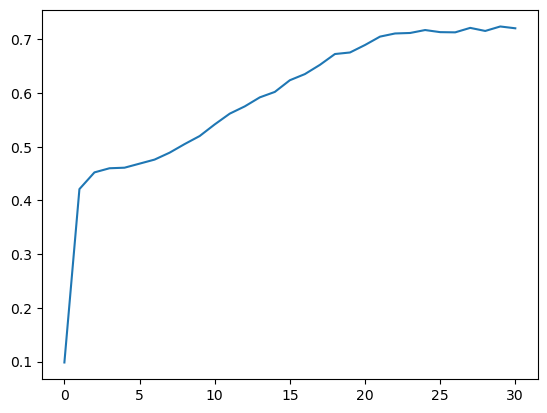

In [152]:
plt.plot(train_results['test_accs'])